In [1]:
from iads.nlp import preprocessing

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from langdetect import detect

# I. Chargement des données :

In [2]:
df_jeux_up = pd.read_csv("../data/details_categ.csv")

In [3]:
df_jeux_up.head()

,Nombre d'avis,Note,categories,description,titre,_id,creators,illustrators,editors,distributors,duration,enfant,ado,adulte,solo,duo,multi
0,19.0,7.58,NaN,\n Marvel United : Unis c...,Marvel United,marvel-united,Eric Lang et Andrea Chiarvesio,Édouard Guiton,CMON Limited,NaN,45.0,0,1,1,1,0,1
1,33.0,7.39,NaN,"\n Chaque année, au print...",Mariposas,mariposas,Elizabeth Hargrave,Matt Paquette et Indi Maverick,Gigamic,NaN,60.0,0,1,1,0,1,1
2,28.0,8.18,placement,\n Vous êtes à la tête d’...,Quetzal,quetzal,Alexandre Garcia,Nastya Lehn,Gigamic,NaN,45.0,0,1,1,0,1,1
3,4.0,9.00,NaN,\n Un Kit de démarrage co...,Alien - Kit de Démarrage,alien-kit-de-demarrage,NaN,NaN,Arkhane Asylum Publishing,NaN,NaN,0,1,1,1,0,1
4,72.0,8.75,gestion,\n Le Dr Foo a créé une t...,The LOOP,the-loop,Maxime Rambourg et Théo Rivière,Simon Caruso,Catch Up Games,NaN,60.0,0,1,1,1,0,1


# II. Netooyage des descriptions :

## 1. Les déscriptions manquantes : 

Les courtes descriptions dans la base de données

In [4]:
df_jeux_up[df_jeux_up["description"].map(str.strip).map(len) < 20]['description'].unique()[:10]

array(['\n                      Aucune description\n                  ',
       '\n                      Le trio magique\n                  ',
       '\n                      Essen 2012\n                  ',
       '\n                      Jeux sur les trains\n\n                  ',
       '\n                      Essen 2012\n\n                  ',
       '\n                      La version voyage\n\n                  ',
       "\n                      L'ancêtre du Mölkky\n                  ",
       '\n                      Duel de dés.\n\n                  ',
       '\n                      Goodies\n                  ',
       '\n                      Tuiles bonus\n                  '],
      dtype=object)

On remarque qu'il y'a des descriptions sous la forme `Aucune description` qu'on supprimera 

In [5]:
print("Le nombre de jeux avec la description 'Aucune description' :")
aucune_desc = df_jeux_up["description"].map(lambda d : "Aucune description" in d)
aucune_desc.astype(int).sum()

Le nombre de jeux avec la description 'Aucune description' :


1857

In [6]:
df_jeux_up["description"] = df_jeux_up["description"].map(str.strip).replace("Aucune description", np.NaN)

In [7]:
print("Apres la suppression de 'Aucune description', nombre de jeux avec cette description :")
aucune_desc = df_jeux_up["description"].map(lambda d : "Aucune description" in d if type(d) == str else False)
aucune_desc.astype(int).sum()

Apres la suppression de 'Aucune description', nombre de jeux avec cette description :


0

## 2. Catégories et Déscriptions :

In [8]:
cat_isna  = df_jeux_up["categories"].isna()
desc_isna = df_jeux_up["description"].isna()

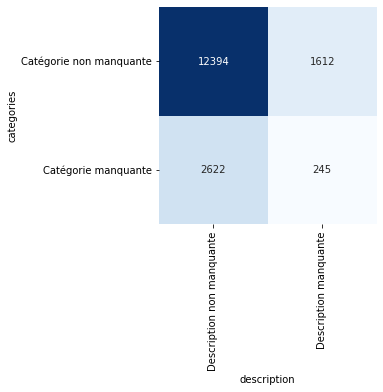

In [9]:
table = pd.crosstab(index=cat_isna, columns=desc_isna, margins=False)
table = table.rename(columns={False: 'Description non manquante', True: 'Description manquante'})
table = table.rename(index={False: 'Catégorie non manquante', True: 'Catégorie manquante'})
sns.heatmap(table, annot=True, cmap='Blues', fmt='g', cbar=False, square=True)
plt.show()

- On remarque qu'il y a 12394 jeux avec une description et une catégorie soit 73% de la base de données, qu'on utilisera pour le train de nos classifers.

- Et il y a aussi 1857 jeux sans description, donc des lignes à "supprimer" pour nos classifiers.

- On voit aussi 2622 avec des descriptions mais sans catégorie, cela on s'en servira pour leur génerer une catégorie avec nos prédicteurs

In [10]:
descriptions = df_jeux_up["description"][~desc_isna]

## 3. Des descriptions dans d'autres langues :

In [11]:
from tqdm import tqdm
tqdm.pandas()

In [12]:
desc_lang = descriptions.progress_apply(detect)
val, count = np.unique(desc_lang, return_counts=True)

index = count.argsort()[::-1]
count = count[index]
val   = val[index]

100%|██████████| 15016/15016 [00:59<00:00, 254.05it/s]


In [13]:
fr = np.where(val == 'fr')[0][0]

count_autre = np.delete(count, fr)

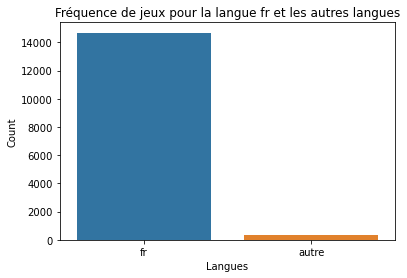

In [14]:
sns.barplot(x = ['fr','autre'], y = [count[fr], count_autre.sum()])
plt.xlabel("Langues")
plt.ylabel("Count")
plt.title("Fréquence de jeux pour la langue fr et les autres langues")
plt.show()

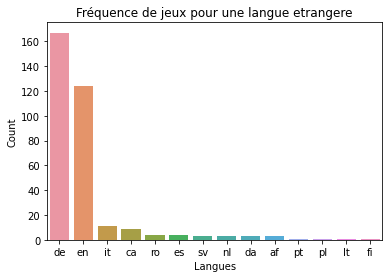

In [15]:
val_autre   = np.delete(val, fr)
count_autre = np.delete(count, fr)
sns.barplot(x = val_autre, y = count_autre)
plt.xlabel("Langues")
plt.ylabel("Count")
plt.title("Fréquence de jeux pour une langue etrangere")
plt.show()

In [16]:
descriptions[desc_lang != "fr"][descriptions[desc_lang != "fr"].map(str.split).map(len) <= 15].unique()[:10]

array(['Promo pack de 5 Mercenaires\n(SG du KS)',
       'Devenez un marchand riche.', 'Projet Kickstarter 2015',
       'Planche bonus pour Heroes Of Normandie : les soldats Siegfried et Bill Furlong',
       'Traduction en français de The Witches: a Discworld Game paru chez Treefrog.',
       'Essen 2012', 'Jeu de pari infernal!',
       'Une extension pour King of Tokyo', 'Essen 2011\nEssen 2012',
       'Carte promotionnelle pour Funkenschlag : Die ersten Funken'],
      dtype=object)

- On remarque que les descriptions de moins de 15mots sont enfaite en français et sont mal prédits par le detecteur de langue (car possede des noms propres),

on decide de mettres juste les longues descriptions à NaN


In [17]:
print("Nombre de descriptions en langues etrangeres :", len(descriptions[desc_lang != "fr"]))
print("Nombre de descriptions en langues etrangeres supprimées :", len(descriptions[desc_lang != "fr"][descriptions[desc_lang != "fr"].map(str.split).map(len) > 15]))

Nombre de descriptions en langues etrangeres : 335
Nombre de descriptions en langues etrangeres supprimées : 96


In [18]:
descriptions[descriptions[desc_lang != "fr"][descriptions[desc_lang != "fr"].map(str.split).map(len) > 15].index] = np.NaN

In [19]:
df_jeux_up["description"][~desc_isna] = descriptions

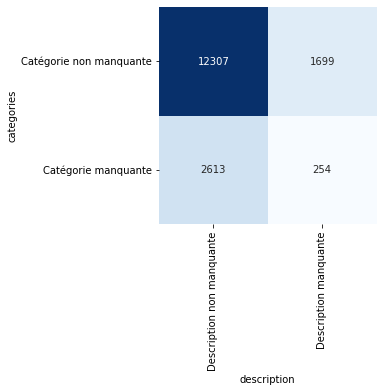

In [20]:
cat_isna  = df_jeux_up["categories"].isna()
desc_isna = df_jeux_up["description"].isna()

table = pd.crosstab(index=cat_isna, columns=desc_isna, margins=False)
table = table.rename(columns={False: 'Description non manquante', True: 'Description manquante'})
table = table.rename(index={False: 'Catégorie non manquante', True: 'Catégorie manquante'})
sns.heatmap(table, annot=True, cmap='Blues', fmt='g', cbar=False, square=True)
plt.show()

## 4. Nettoyer les descriptions :

In [21]:
descriptions = df_jeux_up["description"]
descriptions = descriptions.progress_apply(lambda desc : preprocessing.clean_text(desc) if type(desc) == str else np.NaN)
descriptions = descriptions.progress_apply(lambda desc : preprocessing.tokenize_text(desc) if type(desc) == str else np.NaN)
descriptions = descriptions.progress_apply(lambda tokens : preprocessing.remove_stopwords(tokens, preprocessing.DESC_STOP_WORDS) if type(tokens) == list else np.NaN)


100%|██████████| 16873/16873 [00:00<00:00, 81828.75it/s]


In [22]:
mots = []
descriptions.map(lambda d : mots.extend(d) if type(d) == list else "")

u_mots, count_mots = np.unique(mots, return_counts=True)

In [23]:
descriptions = descriptions.progress_apply(lambda tokens : preprocessing.lemmatize_tokens(tokens) if type(tokens) == list else np.NaN)

100%|██████████| 16873/16873 [03:01<00:00, 92.97it/s] 


In [24]:
descriptions[:10]

0    [marvel, united, unir, contre, super, vilain, ...
1    [annee, printemps, million, papillon, monarque...
2    [tete, groupe, aventurier, archeologue, expedi...
3    [kit, demarrage, complet, plongez, horreur, bo...
4    [dr, foo, cree, terrrribl, machine, voyager, t...
5    [troyes, dice, invite, decouvrir, histoire, vi...
6    [bienvenu, mysterium, park, barbe, papa, cirqu...
7    [guerre, froid, continuer, danger, apparer, ar...
8    [second, extension, not, alone, apporter, nouv...
9    [choisir, personnage, disponible, tenter, plac...
Name: description, dtype: object

In [25]:
mots_lemm = []
descriptions.map(lambda d : mots_lemm.extend(d) if type(d) == list else "")

u_mots_lemm, count_mots_lemm = np.unique(mots_lemm, return_counts=True)

In [26]:
print( "Nombre de mots avant lemmatization :", len(u_mots))
print( "Nombre de mots apres lemmatization :", len(u_mots_lemm))

Nombre de mots avant lemmatization : 52468
Nombre de mots apres lemmatization : 38207


In [27]:
descriptions = descriptions.progress_apply(lambda tokens : preprocessing.remove_stopwords(tokens, preprocessing.DESC_STOP_WORDS) if type(tokens) == list else np.NaN)

100%|██████████| 16873/16873 [00:00<00:00, 96306.17it/s]


In [28]:
mots_clean = []
descriptions.map(lambda d : mots_clean.extend(d) if type(d) == list else "")

u_mots_clean, count_mots_clean = np.unique(mots_clean, return_counts=True)

In [29]:
print( "Nombre de mots avant le 2e sw :", len(u_mots_lemm))
print( "Nombre de mots apres le 2e sw :", len(u_mots_clean))

Nombre de mots avant le 2e sw : 38207
Nombre de mots apres le 2e sw : 38127


Text(0, 0.5, 'counts')

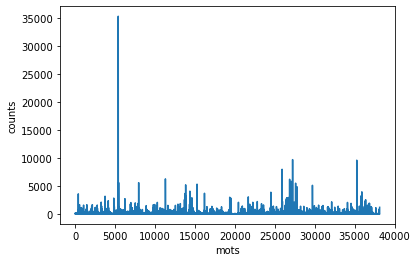

In [30]:
plt.plot(count_mots_clean)
plt.xlabel("mots")
plt.ylabel("counts")


In [31]:
u_mots_clean[count_mots_clean > 5000]

array(['carte', 'case', 'couleur', 'dé', 'faire', 'gagner', 'partie',
       'pion', 'plateau', 'point', 'pouvoir', 'regle', 'tour'],
      dtype='<U45')

Les mots les plus fréquents nous apparaissent assez pertinents, on décide de les garder.

In [32]:
descriptions = descriptions.progress_apply(lambda tokens : " ".join(tokens) if type(tokens) == list else np.NaN)
df_jeux_up["description"] = descriptions

df_jeux_up.to_csv('../data/details_desc.csv', index=False)

100%|██████████| 16873/16873 [00:00<00:00, 383879.51it/s]
